# IT3385 Multiclass Classification (Wheat Seeds)

In [1]:
# check installed version
import pycaret
pycaret.__version__

'3.3.2'

## Reading in the dataset

In [2]:
import pandas as pd

df = pd.read_csv("Datasets/03_Wheat_Seeds.csv")
df.head()

,Area,Perimeter,Compactness,Length,Width,AsymmetryCoeff,Groove,Type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


## Data pre-processing

the code below checks the number of rows and columns the dataset has

In [3]:
df.shape

(199, 8)

checking for duplicated data

In [4]:
df.duplicated().sum()

0

checking for null values

In [5]:
df.isnull().sum()

Area              0
Perimeter         0
Compactness       0
Length            0
Width             0
AsymmetryCoeff    0
Groove            0
Type              0
dtype: int64

showcasing the data types via the data.info()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Area            199 non-null    float64
 1   Perimeter       199 non-null    float64
 2   Compactness     199 non-null    float64
 3   Length          199 non-null    float64
 4   Width           199 non-null    float64
 5   AsymmetryCoeff  199 non-null    float64
 6   Groove          199 non-null    float64
 7   Type            199 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


displaying the min & max values of each column so that during the predicting later on in the web application we know the range of values to be inserted 


In [49]:
for col in df.columns:
    print(f"Max value of {col}: {df[col].max()}")


Max value of Area: 21.18
Max value of Perimeter: 17.25
Max value of Compactness: 0.9183
Max value of Length: 6.675
Max value of Width: 4.033
Max value of AsymmetryCoeff: 8.315
Max value of Groove: 6.55
Max value of Type: 3
Max value of Length_Width_Ratio: 2.032860343539955


In [48]:
for col in df.columns:
    print(f"Min value of {col}: {df[col].min()}")


Min value of Area: 10.59
Min value of Perimeter: 12.41
Min value of Compactness: 0.8081
Min value of Length: 4.899
Min value of Width: 2.63
Min value of AsymmetryCoeff: 0.7651
Min value of Groove: 4.519
Min value of Type: 1
Min value of Length_Width_Ratio: 1.497208263539922


#### correlation matrix of features
this correlation martrix shows the relationships between different wheat kernel measurements and type. 
Some stronger positive correlations: 
- Area and Perimeter (0.99) - almost perfectly correlated
- Area and Width (0.97)
- Area and Length (0.95)
- Length and Perimeter (0.97)
- Length and Groove (0.93)

Moderate to Weak Negative Correlations:
Type has negative correlations with most physical measurements:
- Type vs Compactness (-0.54)
- Type vs Width (-0.42)
- Type vs Area (-0.34)
- Type vs Perimeter (-0.32)

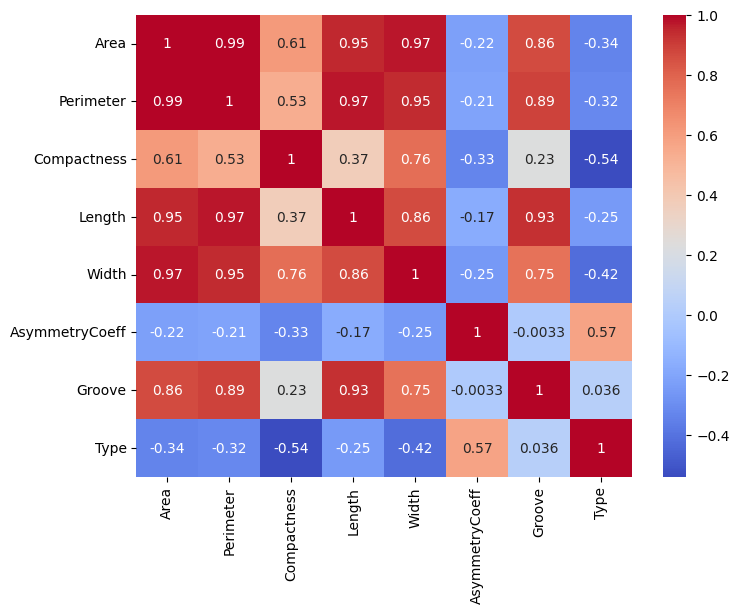

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()


#### Bar graph of Type of seeds

as you can see the bargraph below shows the count of each type of seeds. It is rather balanced where type 1 has 66, type 2 has 68 and type 3 has 65. It could be better balanced out with equal counts from each class to prevent biasness in the model

Type
2    68
1    66
3    65
Name: count, dtype: int64


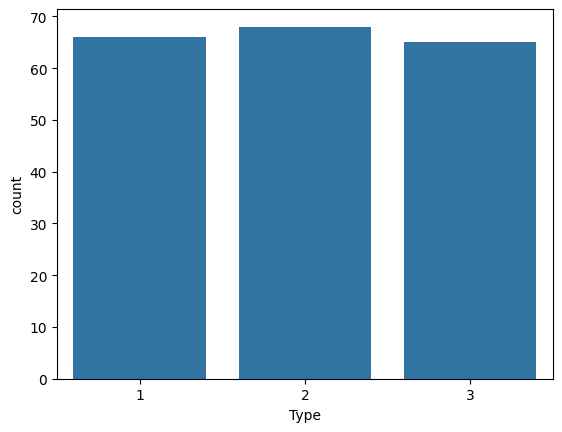

In [9]:
print(df['Type'].value_counts())
sns.countplot(x='Type', data=df)
plt.show()

#### boxplot of distribution by wheat type

this box plot shows the compactness distribution for the 3 types of wheat. The y-axis represents "Compactness" values ranging from approximately 0.81 to 0.92, while the x-axis categorizes the wheat types by number (1, 2, and 3). A wheat kernel with higher compactness has a more rounded, compact shape, while lower compactness indicates a more elongated or irregular shape.


- The compactness values generally range from about 0.81 to 0.92 across all wheat types.
- Rosa wheat (type 2) appears to have:
    - The highest median compactness (around 0.88)
    - A relatively large spread in values
    - Fairly symmetric distribution


- Kama wheat (type 1) shows:
    - Similar median compactness to Rosa
    - Two outliers (shown as circles)
    - Slightly smaller spread than Rosa

- Canadian wheat (type 3) demonstrates:
    - The lowest median compactness (approximately 0.85)
    - Less variation compared to the other two types
    - No visible outliers

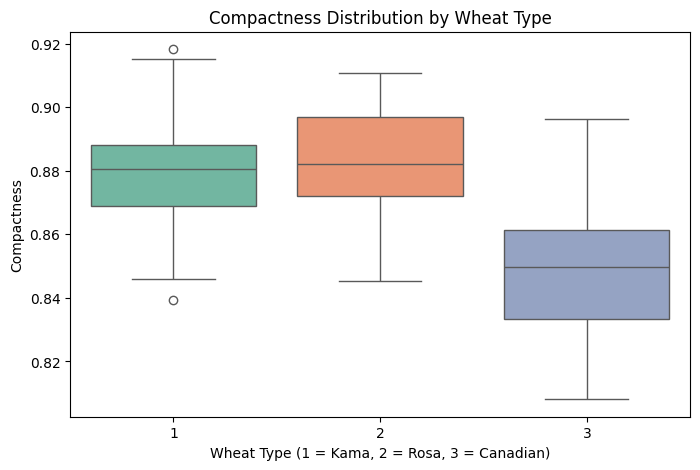

In [10]:
# Boxplot: Compactness by Wheat Type
plt.figure(figsize=(8, 5))
sns.boxplot(x='Type', y='Compactness', data=df, palette='Set2')
plt.title('Compactness Distribution by Wheat Type')
plt.xlabel('Wheat Type (1 = Kama, 2 = Rosa, 3 = Canadian)')
plt.ylabel('Compactness')
plt.show()



#### Correlation values and bar graph against the target column (Type)

first we have the correlation values that are shown of each column against the target column. I then proceeded to plot a bargraph for clearer visualisation and you can see that AsymmetryCoeff has the highest positive correlation and compactness has the highest negative correlation. Along side with the rest of the columns being negatively correlated to the target column, only groove has a positive correlation at a very small value of 0.03 

In [11]:
# Calculate correlation of all features with the 'Type' column
correlation_with_target = df.corr()['Type'].drop('Type')

# Sort the values by absolute correlation (highest to lowest)
sorted_correlations = correlation_with_target.abs().sort_values(ascending=False)

# Print the actual correlation values (with signs) in the sorted order
print(correlation_with_target[sorted_correlations.index])

AsymmetryCoeff    0.573956
Compactness      -0.539261
Width            -0.421961
Area             -0.340664
Perimeter        -0.322223
Length           -0.249422
Groove            0.035508
Name: Type, dtype: float64


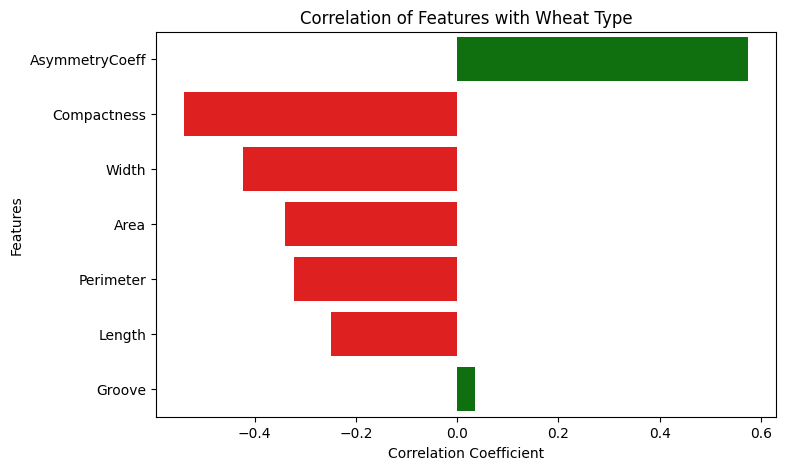

In [12]:
# Sort by absolute value but keep original values
sorted_indices = correlation_with_target.abs().sort_values(ascending=False).index
sorted_corr = correlation_with_target[sorted_indices]

# Plot with original values
plt.figure(figsize=(8, 5))
# Create a custom palette - red for negative, green for positive
colors = ['green' if x >= 0 else 'red' for x in sorted_corr]
sns.barplot(x=sorted_corr, y=sorted_corr.index, palette=colors)

plt.title('Correlation of Features with Wheat Type')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

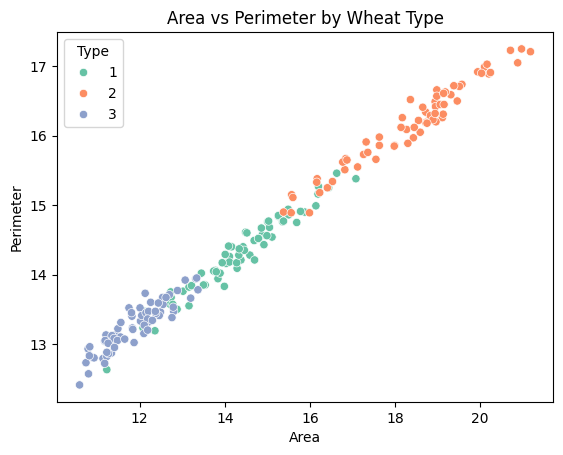

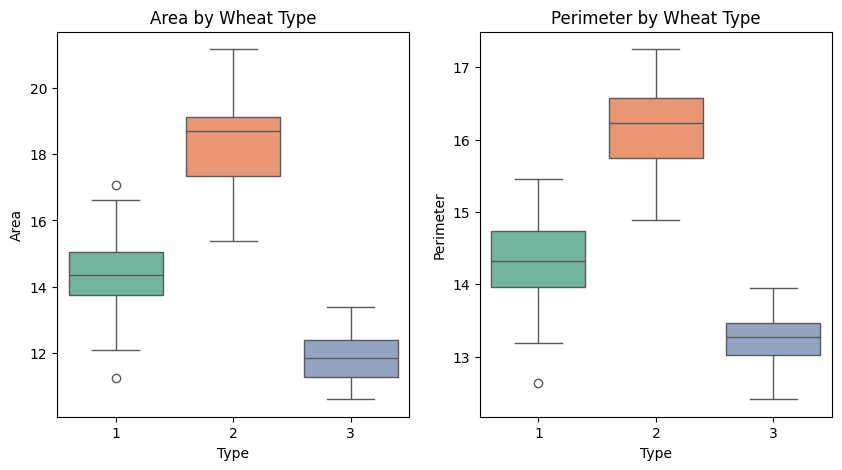

In [13]:
# Correlation between Area and Perimeter
sns.scatterplot(x='Area', y='Perimeter', hue='Type', data=df, palette='Set2')
plt.title('Area vs Perimeter by Wheat Type')
plt.show()

# Boxplot by Type
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='Type', y='Area', data=df, palette='Set2')
plt.title('Area by Wheat Type')

plt.subplot(1, 2, 2)
sns.boxplot(x='Type', y='Perimeter', data=df, palette='Set2')
plt.title('Perimeter by Wheat Type')
plt.show()



#### length/width ratio by wheat type

The Length/Width Ratio is a shape descriptor that tells us how elongated the wheat seeds are, independent of their absolute size. A higher ratio indicates more elongated seeds, while a lower ratio suggests more rounded seeds.
This ratio effectively separates Type 3 from the others, which explains why it's valuable for classification. 

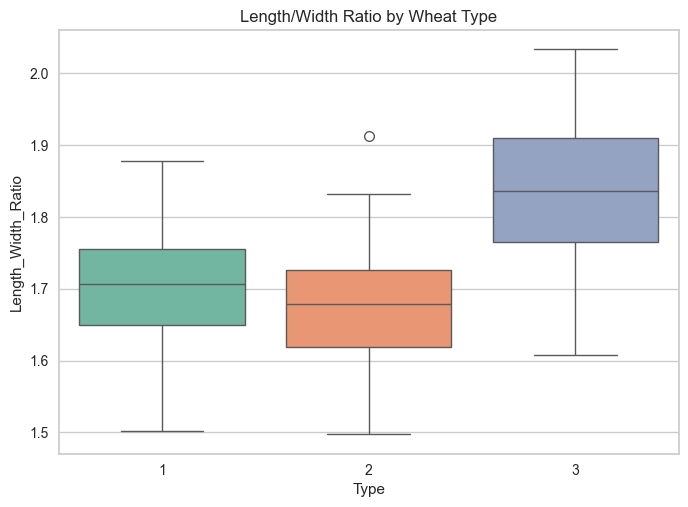

In [19]:
# Length-to-Width Ratio
df['Length_Width_Ratio'] = df['Length'] / df['Width']

sns.boxplot(x='Type', y='Length_Width_Ratio', data=df, palette='Set2')
plt.title('Length/Width Ratio by Wheat Type')
plt.show()

#### Unseen data

setting aside random 5 samples for testing out the final model later on

In [20]:
# Set aside 5 records for unseen data
unseen = df.sample(n=5, random_state=42)
unseen

,Area,Perimeter,Compactness,Length,Width,AsymmetryCoeff,Groove,Type,Length_Width_Ratio
82,18.88,16.26,0.8969,6.084,3.764,1.649,6.109,2,1.616366
15,13.99,13.83,0.9183,5.119,3.383,5.234,4.781,1,1.513154
111,18.96,16.20,0.9077,6.051,3.897,4.334,5.750,2,1.552733
177,11.81,13.45,0.8198,5.413,2.716,4.898,5.352,3,1.993004
76,16.53,15.34,0.8823,5.875,3.467,5.532,5.880,2,1.694549


## setting up pycaret

setting up the pycaret, seting the tracking uri and also the set up which includes the comments below

In [29]:
import mlflow
import logging
mlflow.set_tracking_uri("http://127.0.0.1:5000")
# Set logging to ERROR level to hide warnings and info
logging.getLogger("mlflow").setLevel(logging.ERROR)

In [30]:
from pycaret.classification import *
s = setup(data=df, 
            target='Type',
            experiment_name='typeOfWheat',
            normalize=True,                 #normalize data for better performance
            fix_imbalance=True,             #to deal with the data imbalanced classes
            remove_outliers=True,           #allows for automatic outlier detection and removal from the data
            outliers_method='iforest',      # uses Isolation Forest (less aggressive)
            outliers_threshold=0.02,        #detect and remove only 2% of outliers
            log_experiment = True,
            session_id=123) 

,Description,Value
0,Session id,123
1,Target,Type
2,Target type,Multiclass
3,Target mapping,"1: 0, 2: 1, 3: 2"
4,Original data shape,"(199, 9)"
5,Transformed data shape,"(198, 9)"
6,Transformed train set shape,"(138, 9)"
7,Transformed test set shape,"(60, 9)"
8,Numeric features,8
9,Preprocess,True


In [31]:
get_config()

{'USI',
 'X',
 'X_test',
 'X_test_transformed',
 'X_train',
 'X_train_transformed',
 'X_transformed',
 '_available_plots',
 '_ml_usecase',
 'data',
 'dataset',
 'dataset_transformed',
 'exp_id',
 'exp_name_log',
 'fix_imbalance',
 'fold_generator',
 'fold_groups_param',
 'fold_shuffle_param',
 'gpu_n_jobs_param',
 'gpu_param',
 'html_param',
 'idx',
 'is_multiclass',
 'log_plots_param',
 'logging_param',
 'memory',
 'n_jobs_param',
 'pipeline',
 'seed',
 'target_param',
 'test',
 'test_transformed',
 'train',
 'train_transformed',
 'variable_and_property_keys',
 'variables',
 'y',
 'y_test',
 'y_test_transformed',
 'y_train',
 'y_train_transformed',
 'y_transformed'}

In [32]:
transform_Data = get_config('dataset_transformed')
transform_Data

,Area,Perimeter,Compactness,Length,Width,AsymmetryCoeff,Groove,Length_Width_Ratio,Type
183,-1.061445,-1.236602,0.442665,-1.233692,-0.813819,-0.107008,-0.646028,-0.078686,2
8,0.543179,0.510066,0.810335,0.552136,0.676540,-1.203288,0.216600,-0.613352,0
80,1.621122,1.653624,0.377784,1.696778,1.475718,-0.534611,1.619176,-0.648806,1
128,0.444865,0.572727,-0.210485,0.459520,0.379548,0.343490,0.780212,-0.225522,1
108,1.491206,1.575299,0.126904,1.442676,1.302922,1.970402,1.335219,-0.648350,1
...,...,...,...,...,...,...,...,...,...
19,-0.257378,-0.155705,-0.470018,0.015438,-0.338633,-0.460538,-0.551375,0.557244,0
49,0.311439,0.243758,0.996332,0.053434,0.484845,1.237080,-0.637423,-0.852389,0
170,-0.942064,-0.884136,-1.036658,-0.699369,-0.975815,-1.410693,-0.547073,0.950143,2
47,-0.011593,0.055775,-0.072069,0.062934,0.009658,-1.095546,-0.174917,-0.034454,0


In [33]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [34]:
#to see which is the best model
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.9786,0.0000,0.9786,0.9824,0.9783,0.9677,0.9698,0.1590
lda,Linear Discriminant Analysis,0.9643,0.0000,0.9643,0.9710,0.9641,0.9464,0.9499,0.1050
gbc,Gradient Boosting Classifier,0.9500,0.0000,0.9500,0.9614,0.9484,0.9252,0.9316,0.3440
svm,SVM - Linear Kernel,0.9489,0.0000,0.9489,0.9586,0.9476,0.9235,0.9291,0.1420
xgboost,Extreme Gradient Boosting,0.9423,0.9920,0.9423,0.9583,0.9418,0.9140,0.9219,0.2230
dt,Decision Tree Classifier,0.9357,0.9528,0.9357,0.9495,0.9338,0.9036,0.9114,0.1310
lr,Logistic Regression,0.9346,0.0000,0.9346,0.9465,0.9331,0.9024,0.9088,5.5750
catboost,CatBoost Classifier,0.9280,0.9953,0.9280,0.9442,0.9277,0.8926,0.9005,4.4100
qda,Quadratic Discriminant Analysis,0.9214,0.0000,0.9214,0.9367,0.9193,0.8822,0.8910,0.1570
rf,Random Forest Classifier,0.9209,0.9940,0.9209,0.9369,0.9188,0.8815,0.8905,0.3520


as you can see the best model is the ridge classifier with the highest accuracy of 0.9786

In [35]:
best

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, positive=False, random_state=123, solver='auto',
                tol=0.0001)

I proceeded to attempt to finetune the model and decided to use the MCC as the optimiser as givent that the  accuracy, recall, and F1-score are all high, optimizing MCC might further enhance generalization. 

however as you can see, after finetuning the model did not do better than the original model, with its accuracy at 0.9643 which is lower than the original model of 0.9786. Therefore i will be using the ridge model before tuning as the best model

In [36]:
tuned_model = tune_model(best, optimize='MCC')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9286,0.0000,0.9286,0.9405,0.9267,0.8915,0.8985
2,0.9286,0.0000,0.9286,0.9429,0.9286,0.8931,0.9000
3,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.9286,0.0000,0.9286,0.9429,0.9286,0.8931,0.9000
5,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,0.9286,0.0000,0.9286,0.9405,0.9278,0.8923,0.8993
7,0.9286,0.0000,0.9286,0.9429,0.9286,0.8931,0.9000
8,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [37]:
# Create the random forest model (best model)
ridge = create_model('ridge')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9286,0.0000,0.9286,0.9405,0.9267,0.8915,0.8985
2,0.9286,0.0000,0.9286,0.9429,0.9286,0.8931,0.9000
3,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,0.9286,0.0000,0.9286,0.9405,0.9278,0.8923,0.8993
7,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000


This confusion matrix shows excellent classification performance for the wheat seed types
Class 0 (Type 1 Kama): 19 correct predictions, 1 misclassified as Type 3
Class 1 (Type 2 Rosa): 20 correct predictions, no misclassifications
Class 2 (Type 3 Canadian): 19 correct predictions, 1 misclassified as Type 1
Overall accuracy is very high (58/60 = ~96.7%)
There's a small amount of confusion between Types 1 and 3, but none with Type 2

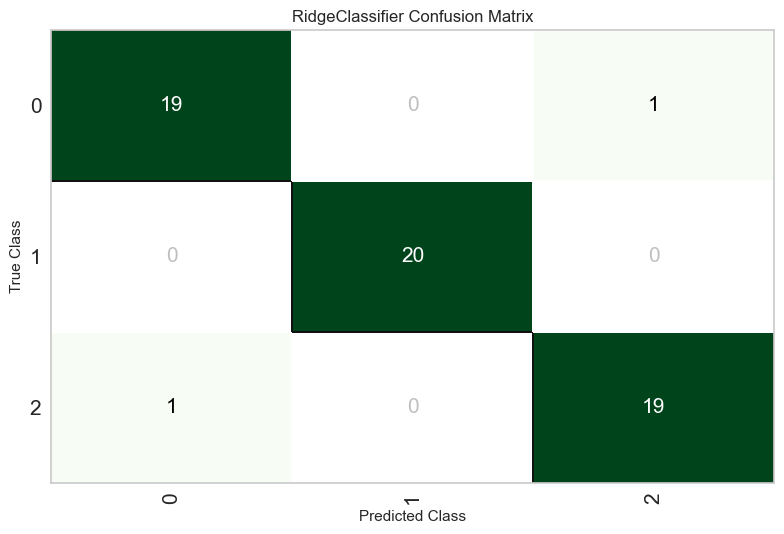

In [38]:
plot_model(ridge, plot='confusion_matrix')

This features importance plot shows how important each features are to preict the type of wheat. As you can see below the more important feature is groove with 1.4 varieble importance and width being the least important. Overall all these features play a part in predicting the type of wheat but just through this feature plot, we are able to see which feature has the most impact.

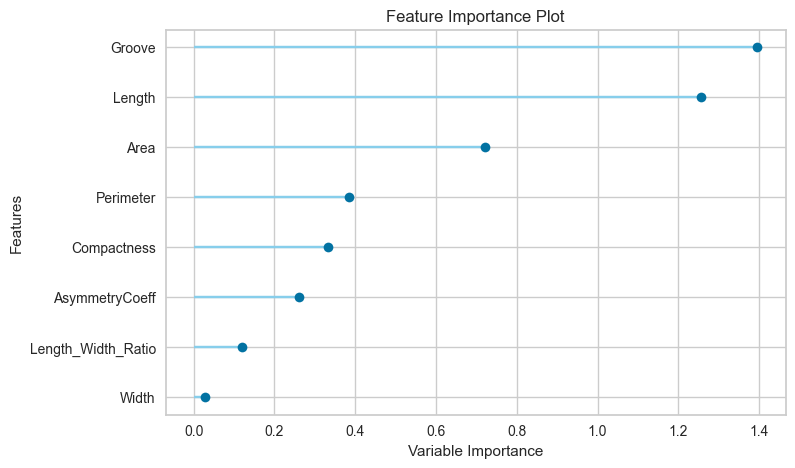

In [39]:
plot_model(ridge, plot='feature')


this is a decision boundary visualization which shows how the model separates the three wheat types after dimensionality reduction to two features
The colored regions represent the decision boundaries where the model predicts each class
Red region: Type 2 (diamonds)
Blue region: Type 0 (squares)
Light green region: Type 1 (circles)
Most data points fall correctly within their class boundaries
A few points appear near the boundary edges, which explains the small number of misclassifications in the confusion matrix
The small overlap between Types 1 and 3 in the decision boundary corresponds with the confusion seen in the matrix above as well

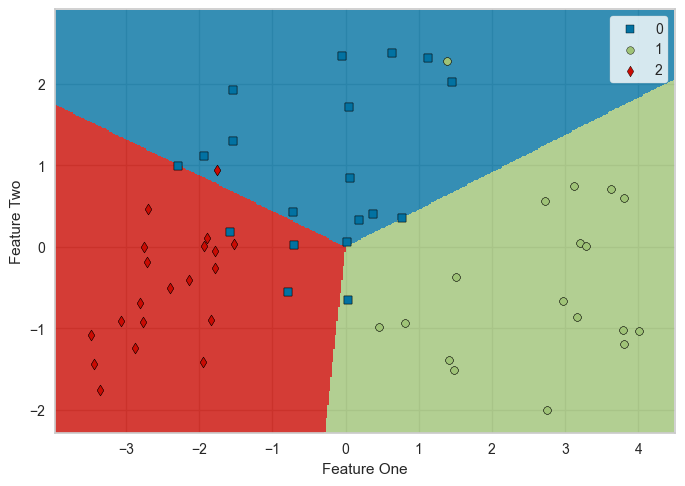

In [40]:
plot_model(ridge, plot='boundary')


These visualizations provide strong validation that your machine learning pipeline is performing well for wheat seed classification. The Ridge Classifier with the features you've selected creates well-defined decision boundaries that accurately separate the different wheat types with minimal error.

#### Making predictions to the model

you can see with the pycraret predict_model fuction, the model accuracy is 0.9667 which is slightly lower than the training accuracy but overal still pretty close which shows that the model is realiable in predicting the type of wheat. Theres Minimal Overfitting as seen in the small difference (about 1.2 ) which indicates the model has generalized well to new data rather than memorizing the training set.

In [41]:
predict_model(ridge)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.9667,0,0.9667,0.9667,0.9667,0.9500,0.9500


,Area,Perimeter,Compactness,Length,Width,AsymmetryCoeff,Groove,Length_Width_Ratio,Type,prediction_label
84,21.180000,17.209999,0.8989,6.573,4.033,5.780,6.231,1.629804,2,2
9,15.260000,14.850000,0.8696,5.714,3.242,4.543,5.314,1.762492,1,1
69,19.110001,16.260000,0.9081,6.154,3.930,2.936,6.079,1.565903,2,2
141,12.490000,13.460000,0.8658,5.267,2.967,4.421,5.002,1.775194,3,3
114,20.030001,16.900000,0.8811,6.493,3.857,3.063,6.320,1.683433,2,2
61,12.780000,13.570000,0.8716,5.262,3.026,1.176,4.782,1.738929,1,1
88,18.809999,16.290001,0.8906,6.272,3.693,3.237,6.053,1.698348,2,2
83,18.980000,16.660000,0.8590,6.549,3.670,3.691,6.498,1.784469,2,2
59,12.360000,13.190000,0.8923,5.076,3.042,3.220,4.605,1.668639,1,1
36,14.800000,14.520000,0.8823,5.656,3.288,3.112,5.309,1.720195,1,1


#### Testing the model with the unseen data that we have set aside earlier

you can see that the model correctly identified each type with an accuracy of 1.0 which means that the model did very well

In [42]:
unseen

,Area,Perimeter,Compactness,Length,Width,AsymmetryCoeff,Groove,Type,Length_Width_Ratio
82,18.88,16.26,0.8969,6.084,3.764,1.649,6.109,2,1.616366
15,13.99,13.83,0.9183,5.119,3.383,5.234,4.781,1,1.513154
111,18.96,16.20,0.9077,6.051,3.897,4.334,5.750,2,1.552733
177,11.81,13.45,0.8198,5.413,2.716,4.898,5.352,3,1.993004
76,16.53,15.34,0.8823,5.875,3.467,5.532,5.880,2,1.694549


In [43]:
predict_model(ridge, data=unseen)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,1.0000,0,1.0000,1.0000,1.0000,1.0000,1.0000


,Area,Perimeter,Compactness,Length,Width,AsymmetryCoeff,Groove,Length_Width_Ratio,Type,prediction_label
82,18.879999,16.260000,0.8969,6.084,3.764,1.649,6.109,1.616366,2,2
15,13.990000,13.830000,0.9183,5.119,3.383,5.234,4.781,1.513154,1,1
111,18.959999,16.200001,0.9077,6.051,3.897,4.334,5.750,1.552733,2,2
177,11.810000,13.450000,0.8198,5.413,2.716,4.898,5.352,1.993004,3,3
76,16.530001,15.340000,0.8823,5.875,3.467,5.532,5.880,1.694549,2,2


#### Saving the pipline

In [53]:
save_model(ridge, 'seed_type_classification')


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Area', 'Perimeter', 'Compactness',
                                              'Length', 'Width',
                                              'AsymmetryCoeff', 'Groove',
                                              'Length_Width_Ratio'],
                                     transformer=SimpleImputer(add_indicator=Fa...
                                                                               random_state=123,
                                                                               sampling_strategy='auto')))),
                 ('normalize',
                  TransformerWrapper(exclude=None, include=None,
     

In [54]:
# Load the entire pipeline
seed_pipeline = load_model('seed_type_classification')

# Save it using pickle with protocol version 4
with open('seed_pipeline.pkl', 'wb') as file:
    pickle.dump(seed_pipeline, file, protocol=4)

Transformation Pipeline and Model Successfully Loaded


#### Resgistering the model to MLFLOW

with the earlier code to set tracking uri as well as the setting of experiment name all leads to this registering with MLFLOW

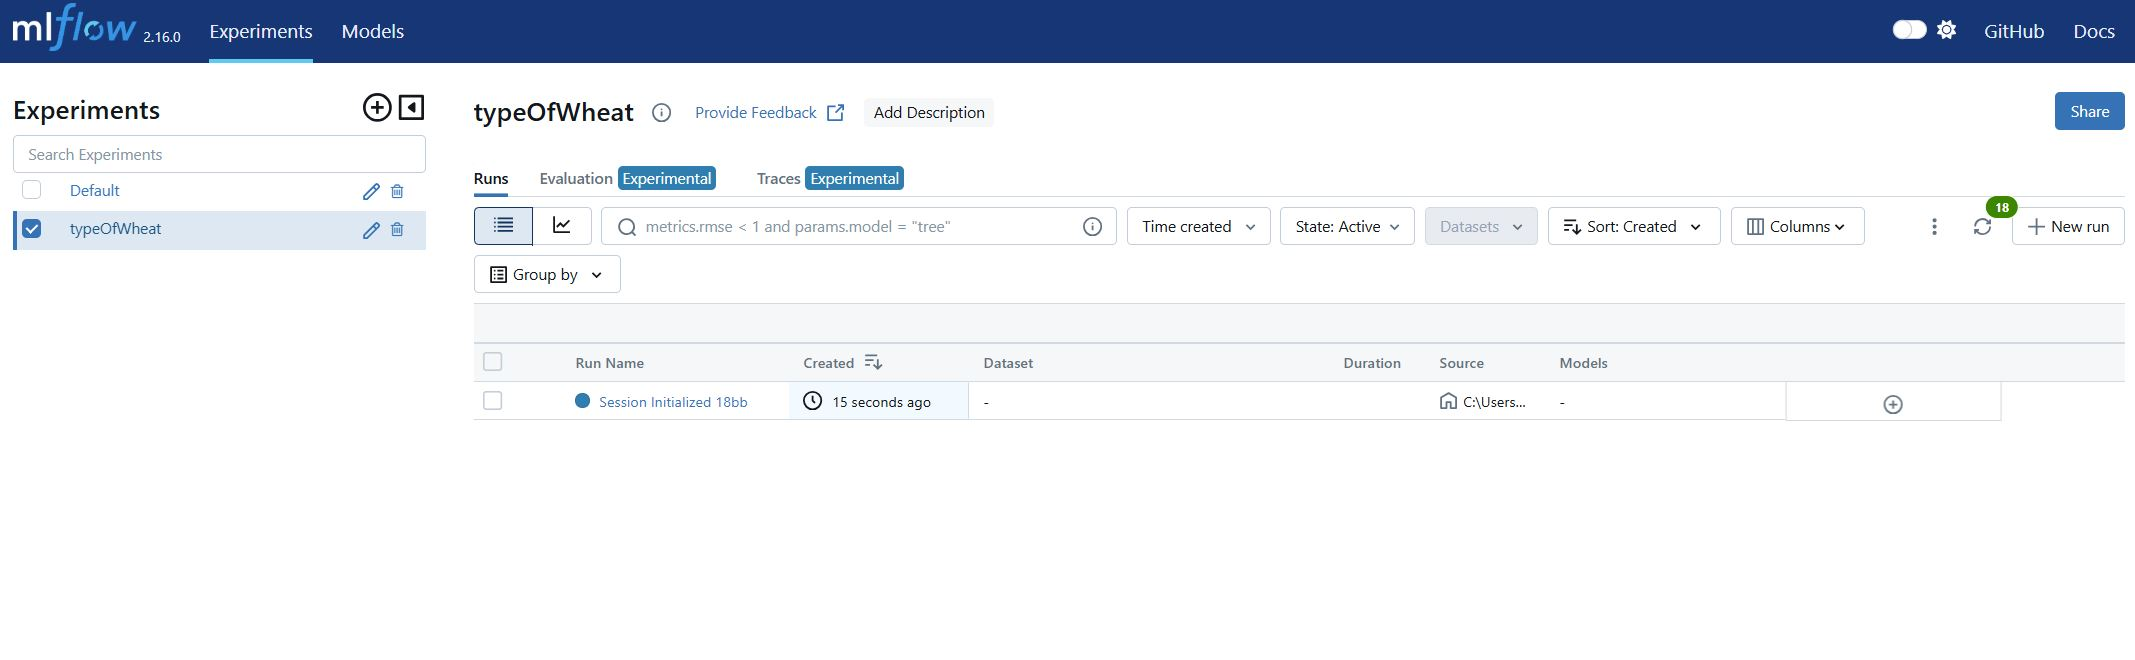

In [47]:
from IPython.display import Image, display

display(Image(filename="mlflow.JPG"))
